## 목적
- 주요 모델들 해석 및 개선
- 대상
    1. 제조사
    2. 가격대
    3. 노트 여부

In [1]:
import lightgbm as lgb
import pandas as pd
import numpy as np
import pickle
import time
import os
import gc

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from dateutil.relativedelta import relativedelta
from datetime import datetime

import shap
shap.initjs()

from tigger.util.hive_tools import hive_connection, load_from_hive, load_to_hive, send_query

In [2]:
DATA_PATH = '/home/dmig/work/dominic_workspace/data/'
MODEL_PATH = '/home/dmig/work/dominic_workspace/model/'

In [9]:
df_meta[df_meta['note_yn']=='Y']

eqp_mdl_cd rep_eqp_mdl_cd           eqp_nm_rmk     eqp_pet_nm mfact_nm  \
9          A016           A015   IPAD PRO 12.9_64GW  IPAD PRO 12.9    Apple   
10         A01C           A01C   IPAD PRO 12.9_512G  IPAD PRO 12.9    Apple   
11         A01D           A01C  IPAD PRO 12.9_512GW  IPAD PRO 12.9    Apple   
12         A01F           A01F    IPAD PRO 10.5_64G  IPAD PRO 10.5    Apple   
13         A01K           A01K   IPAD PRO 10.5_256G  IPAD PRO 10.5    Apple   
...         ...            ...                  ...            ...      ...   
1646       SSU8           SS4B           갤럭시노트5_64G         갤럭시노트5  삼성전자(주)   
1647       SSU9           SSO2           갤럭시노트5_32G         갤럭시노트5  삼성전자(주)   
1660       SSVM           SSVM               갤럭시노트3         갤럭시노트3  삼성전자(주)   
1661       SSVQ           SSVM               갤럭시노트3         갤럭시노트3  삼성전자(주)   
1662       SSVR           SSVM               갤럭시노트3         갤럭시노트3  삼성전자(주)   

       mktg_dt smart_phon_yn tablet_yn note_yn disp_size_larg_yn  \
9     20170713             N         Y       Y                 N   
10    20170713             N         Y       Y                 N   
11    20170713             N         Y       Y                 N   
12    20170713             N         Y       Y                 N   
13    20170713             N         Y       Y                 N   
...        ...           ...       ...     ...               ...   
1646  20150923             Y         N       Y                 Y   
1647  20151023             Y         N       Y                 Y   
1660  20130923             Y         N       Y                 Y   
1661  20130923             Y         N       Y                 Y   
1662  20130923             Y         N       Y                 Y   

          eqp_siz_ctt flagship_yn eqp_mdl_size eqp_mdl_ntwk  first_eqp_out_prc  
9     305.7*220.6*6.9           N         64GB           4G          1120900.0  
10    305.7*220.6*6.9           N        512GB           4G          1452000.0  
11    305.7*220.6*6.9           N        512GB           4G          1452000.0  
12    250.6*174.1*6.1           N         64GB           4G           935000.0  
13    250.6*174.1*6.1           N        256GB           4G          1046100.0  
...               ...         ...          ...          ...                ...  
1646              TBD           Y         64GB           4G           965800.0  
1647              TBD           Y         32GB           4G                NaN  
1660   151.2*79.2*8.3           Y         32GB           4G          1067000.0  
1661   151.2*79.2*8.3           Y         32GB           4G          1067000.0  
1662   151.2*79.2*8.3           Y         32GB           4G          1067000.0  

[240 rows x 15 columns]

## load data

In [3]:
df_merge = pd.read_pickle(os.path.join(DATA_PATH, 'eqp_merge_le.pkl'))
df_meta = pd.read_pickle(os.path.join(DATA_PATH, 'eqp_meta.pkl'))

df_merge.shape, df_meta.shape

((1494418, 330), (1679, 15))

In [4]:
with open(os.path.join(DATA_PATH, 'eqp_le_dict.pkl'), 'rb') as f:
    le_dict = pickle.load(f)

In [ ]:
df_merge['label_price_range'] = df_merge['label_out_prc'].apply(lambda x: 1600000 if x > 1600000 else x)
df_merge['label_price_range'] = pd.cut(df_merge['label_price_range'], bins=np.arange(0,1600001, 400000), labels=np.arange(0,4))

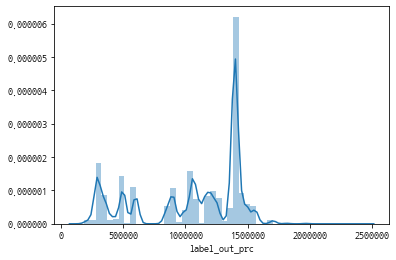

In [6]:
sns.set(rf={'figure.figsize': (20,5)})
sns.distplot(df_merge['label_out_prc'])

In [ ]:
# data
df_trn = df_merge[df_merge['ym'].isin(['201902', '201903', '201904', '201905'])]
df_val = df_merge[df_merge['ym']=='201906']
df_tst = df_merge[df_merge['ym']=='201907']

df_trn.shape, df_val.shape, df_tst.shape

In [ ]:
label_cols = [c for c in df_trn.columns if 'label_' in c]

idx_col = 'svc_mgmt_num'
target_cols = ['label_mfact_nm', 'label_price_range', 'label_tablet_yn', 'label_note_yn', 'label_flagship_yn', 'label_disp_size_larg_yn']

feature_cols = [c for c in df_trn.columns if c not in [idx_col, 'ym', 'next_ym'] + label_cols ]

## load model

In [ ]:
label_dict = {
    'label_price_range': 'multi',
    'label_mfact_nm': 'multi',
#     'label_tablet_yn': 'binary',
    'label_note_yn': 'binary',
#     'label_flagship_yn': 'binary',
#     'label_disp_size_larg_yn': 'binary'
}

In [ ]:
clf_dict = {}

for name in label_dict.keys():
    model_name = 'clf_' + '_'.join(name.split('_')[1:]) + '.pkl'
    with open(os.path.join(DATA_PATH, model_name), 'rb') as f:
        clf_dict[name] = pickle.load(f)

## preprocess

In [ ]:
df_merge['label_price_range'] = df_merge['label_out_prc'].apply(lambda x: 1600000 if x > 1600000 else x)
df_merge['label_price_range'] = pd.cut(df_merge['label_price_range'], bins=np.arange(0,1600001, 400000), labels=np.arange(0,4))

## predict

In [ ]:
for label, p_type in label_dict.items():
    print('label: ', label)
    
    pred_col = 'pred_' + '_'.join(label.split('_')[1:])
    
    if p_type == 'multi':
        df_merge[pred_col] = clf_dict[label].predict(df_merge[feature_cols]).argmax(axis=1)
    else:
        df_merge[pred_col] = clf_dict[label].predict(df_merge[feature_cols])

In [ ]:
# data
df_trn = df_merge[df_merge['ym'].isin(['201902', '201903', '201904', '201905'])]
df_val = df_merge[df_merge['ym']=='201906']
df_tst = df_merge[df_merge['ym']=='201907']

df_trn.shape, df_val.shape, df_tst.shape

In [ ]:
df_trn.shape

## interprete

In [ ]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, precision_recall_curve
from sklearn.metrics import f1_score, confusion_matrix, roc_auc_score, average_precision_score

In [ ]:
from shap_tools import ShapModule

In [ ]:
def make_multi_confusion_matrix(df_tst, target_col):
    label_col = 'label_' + target_col
    pred_col = 'pred_' + target_col
    
    if target_col == 'price_range':
        cols = np.arange(0,1600001, 400000)[1:]
    else:
        cols = le_dict[target_col].classes_
    
    df_cf = pd.DataFrame(
        confusion_matrix(df_tst[label_col], df_tst[pred_col], labels=np.arange(df_tst[label_col].nunique())), 
        columns = cols)
    
    df_cf['Sum'] = df_cf.sum(axis=1)
    df_cf = df_cf.append(df_cf.sum(axis=0), ignore_index=True)
    
    idx_list = list(cols) + ['Total']
    idx_dict = {}
    for i in np.arange(len(idx_list)):
        idx_dict[i] = idx_list[i]
        
    df_cf.rename(index=idx_dict, inplace=True)
    
    return df_cf

## 1. 제조사 

In [ ]:
trn_acc = accuracy_score(df_trn['label_mfact_nm'], df_trn['pred_mfact_nm'])
val_acc = accuracy_score(df_val['label_mfact_nm'], df_val['pred_mfact_nm'])
tst_Acc = accuracy_score(df_tst['label_mfact_nm'], df_tst['pred_mfact_nm'])

print('train accuracy: ', trn_acc)
print('valid accuracy: ', val_acc)
print('test accuracy: ', tst_Acc)

In [ ]:
make_multi_confusion_matrix(df_trn, 'mfact_nm')

In [ ]:
make_multi_confusion_matrix(df_tst, 'mfact_nm')

- 85% 정도가 삼성전자여서 모델이 대부분을 삼성전자로 예측함(실제:28만, 예측 30만)
- apple과 다르게 lg전자는 많은 수가 삼성으로 예측됨(전체 23만, 삼성으로 예측: 22만) -> 문제임
- 기타는 그래도 기타로 많이 예측함
- 삼성전자도 뭐 대부분 삼성전자로 예측함
- 일단 lg 전자 애들을 맞춰보자
- test만 그런게 아니라 애초에 LG인 애들을 삼성으로 예측함...(그 둘을 나눌 수 있는 변수가 없나봄) -> 만약 LG로 하면? 실제 삼성인 애들을 LG로 예측할 듯

In [ ]:
le_dict['mfact_nm'].classes_

In [ ]:
sm = ShapModule(df_trn, clf_dict['label_mfact_nm'], feature_cols, 'svc_mgmt_num', 'label_mfact_nm',
               {0:'Apple', 1:'LG전자', 2:'기타', 3:'삼성전자'})

In [ ]:
sm.calculate_shap_value()

In [ ]:
sm.multiclass_summary_plot()

In [ ]:
df_trn[df_trn.svc_mgmt_num=='7278624152']

In [ ]:
sm.multiclass_force_plot()

In [ ]:
sm.model_type = 'python'

In [ ]:
y_pred = df_trn['pred_mfact_nm']

In [ ]:
sm.target_col

In [ ]:
len(list(df_trn['label_mfact_nm']))

In [ ]:
y_pred = sm.sample_df['pred_mfact_nm']

In [ ]:
sm.sample_df.label_mfact_nm.value_counts()

In [ ]:
sm.multiclass_summary_plot_for_confusion_matrix(y_pred)

In [ ]:
sm.multiclass_summary_selected(1,3)

In [ ]:
sns.distplot(sm.sample_df[sm.sample_df['label_mfact_nm']==0]['real_avg_arpu'], label='apple')
sns.distplot(sm.sample_df[sm.sample_df['label_mfact_nm']==1]['real_avg_arpu'], label='lg')
sns.distplot(sm.sample_df[sm.sample_df['label_mfact_nm']==3]['real_avg_arpu'], label='samsung')
plt.legend()

In [ ]:
sns.distplot(sm.sample_df[sm.sample_df['label_mfact_nm']==0]['real_avg_arpu'], label='apple')
sns.distplot(sm.sample_df[sm.sample_df['label_mfact_nm']==1]['real_avg_arpu'], label='lg')

In [ ]:
sns.distplot(sm.sample_df[sm.sample_df['label_mfact_nm']==0]['real_avg_arpu'], label='apple')
sns.distplot(sm.sample_df[sm.sample_df['label_mfact_nm']!=0]['real_avg_arpu'], label='lg')

In [ ]:
df_sample[df_sample['label_mfact_nm']!=1].shape

In [ ]:
df_sample[df_sample['label_mfact_nm']==1].shape

In [ ]:
shap.dependence_plot('real_avg_arpu', shap_values[0], df_sample[feature_cols])

In [ ]:
sns.set(rc={'figure.figsize': (20,5)})
sns.distplot(df_sample[df_sample['label_mfact_nm']==0]['real_avg_arpu'], label='lg', bins=np.arange(0, 100000, 5000))
sns.distplot(df_sample[df_sample['label_mfact_nm']!=0]['real_avg_arpu'], label='not lg', bins=np.arange(0, 100000, 5000))
plt.legend()

In [ ]:
sns.set(rc={'figure.figsize': (20,5)})
sns.distplot(df_sample[df_sample['label_mfact_nm']==1]['real_avg_arpu'], label='lg', bins=np.arange(0, 100000, 5000))
sns.distplot(df_sample[df_sample['label_mfact_nm']!=1]['real_avg_arpu'], label='not lg', bins=np.arange(0, 100000, 5000))
plt.legend()

In [ ]:
sm.explainer.expected_value

In [ ]:
import shap

In [ ]:
explainer = shap.TreeExplainer(clf_dict['label_mfact_nm'])

In [ ]:
df_sample = df_trn.sample(n=100000)

In [ ]:
shap_values = explainer.shap_values(df_sample[feature_cols])

In [ ]:
len(shap_values)

In [ ]:
shap_values[1].shape

In [ ]:
le_dict['mfact_nm'].classes_

In [ ]:
shap.dependence_plot('real_avg_arpu', shap_values[1], df_sample[feature_cols])

In [ ]:
sm.multiclass_dependence_plot(target_feature = 'real_avg_arpu')

In [ ]:
sm.sample_df.index

In [ ]:
df_merge['only_lg'] = df_merge['label_mfact_nm'].apply(lambda x: 1 if x==1 else 0)

In [ ]:
# data
df_trn = df_merge[df_merge['ym'].isin(['201902', '201903', '201904', '201905'])]
df_val = df_merge[df_merge['ym']=='201906']
df_tst = df_merge[df_merge['ym']=='201907']

df_trn.shape, df_val.shape, df_tst.shape

In [ ]:
df_trn.head()

In [ ]:
label_dict = {
    'only_lg': 'binary',
}

In [ ]:
def lgb_train(params, train_set, valid_sets):
    t1 = time.time()
    clf = lgb.train(lgb_params,
                    train_set=lgb_trn,
                    valid_sets=[lgb_trn, lgb_val],
                    num_boost_round=2000,
                    early_stopping_rounds=100,
                    verbose_eval=50)
    print('elapsed time:', time.time()-t1)
    return clf

In [ ]:
clf_dict = {}

for label in ['only_lg']:
    print('='*50)
    print('label: ', label)
    
    # input
    lgb_trn = lgb.Dataset(df_trn[feature_cols], df_trn[label], feature_name=feature_cols)
    lgb_val = lgb.Dataset(df_val[feature_cols], df_val[label], feature_name=feature_cols)
    
    # problem type
    p_type = label_dict[label]
    print('p_type: ', p_type)
    
    # params
    lgb_params = {
        'boosting_type': 'gbdt',
        'num_leaves': 31,
        'learning_rate': 0.05,
        'num_threads': 60,
    }
    

    # train
    if p_type=='multi':
        lgb_params['objective'] = 'multiclass'
        lgb_params['num_class'] = df_trn[label].nunique()
        lgb_params['metric'] = 'multi_logloss'
        
    elif p_type=='binary':
        lgb_params['objective'] = 'binary'
        lgb_params['metric'] = 'auc'
        lgb_params['is_unbalance'] = True
        
    else:
        print('ERROR!')
        
    clf = lgb_train(lgb_params, lgb_trn, [lgb_trn, lgb_val])

    clf_dict[label] = clf
    print('')

In [ ]:
from sm_utils import evaluate
label = 'only_lg'
a = evaluate(df_tst[feature_cols], df_tst[label], clf_dict[label], clf_name='lgb' )

In [ ]:
explainer_lg = shap.TreeExplainer(clf_dict['only_lg'])

shap_value_lg = explainer_lg.shap_values(df_sample[feature_cols])

len(shap_value_lg)

In [ ]:
shap.summary_plot(shap_value_lg[1], df_sample[feature_cols])d

In [ ]:
shap.dependence_plot('real_avg_arpu', shap_values[1], df_sample[feature_cols])

In [ ]:
df_sv = pd.DataFrame(shap_value_lg[1], columns=feature_cols, index=df_sample.index)

In [ ]:
df_sv.abs().sum().sort_values()

In [ ]:
target_feature = 'real_avg_arpu'

In [ ]:
df_sample.columns

In [ ]:
df_sample['label_mfact_nm']

In [ ]:
df_sample['only_lg'] = df_sample['label_mfact_nm'].apply(lambda x: 1 if x==1 else 0)

In [ ]:
sns.set(rc={'figure.figsize': (20,5)})

sns.scatterplot(df_sample[target_feature].values,
                df_sv[target_feature].values, hue=df_sample['only_lg'])
plt.title("{}".format(target_feature))
plt.xlabel("real value")
plt.ylabel("shap value")
plt.show()

In [ ]:
sns.set(rc={'figure.figsize': (20,5)})
sns.distplot(df_sample[df_sample['only_lg']==1]['flagship_yn'], label='lg')
sns.distplot(df_sample[df_sample['only_lg']==0]['flagship_yn'], label='not lg')
plt.legend()

In [ ]:
sns.set(rc={'figure.figsize': (20,5)})
sns.distplot(df_sample[df_sample['only_lg']==1]['real_avg_arpu'], label='lg', bins=np.arange(0, 100000, 2500))
sns.distplot(df_sample[df_sample['only_lg']==0]['real_avg_arpu'], label='not lg', bins=np.arange(0, 100000, 2500))
plt.legend()

In [ ]:
shap.force_plot(explainer_lg.expected_value[1], shap_value_lg[1][15,:], df_sample.iloc[15,:][feature_cols])

In [ ]:
le.classes_

In [ ]:
for other in df_sv.abs().sum().sort_values(ascending=False).head(20).index:
    print('='*50)
    print('other: ', other)
    shap.dependence_plot('real_avg_arpu', shap_values[1], df_sample[feature_cols], interaction_index=other)

In [ ]:
for other in df_sv.abs().sum().sort_values(ascending=False).head(20).index:
    print('='*50)
    print('other: ', other)
    shap.dependence_plot(other, shap_values[1], df_sample[feature_cols], interaction_index='real_avg_arpu')

In [ ]:
sns.set(rc={'figure.figsize': (20,5)})
plt.xlim(0,150000)
sns.distplot(df_sample[df_sample['only_lg']==1]['real_avg_arpu'], label='lg', bins=np.arange(0, 100000, 2500))
sns.distplot(df_sample[df_sample['only_lg']==0]['real_avg_arpu'], label='not lg', bins=np.arange(0, 100000, 2500))
plt.legend()

In [ ]:
sns.set(rc={'figure.figsize': (20,5)})
plt.xlim(0,150000)
sns.distplot(df_sample[df_sample['only_lg']==1]['real_arpu_bf_m1'], label='lg', bins=np.arange(0, 100000, 2500))
sns.distplot(df_sample[df_sample['only_lg']==0]['real_arpu_bf_m1'], label='not lg', bins=np.arange(0, 100000, 2500))
plt.legend()

In [13]:
df_merge[df_merge.real_arpu_bf_m3==0].shape[0]/df_merge.shape[0]

0.009340760081851262

In [14]:
df_merge.ym.value_counts()

201907    337001
201906    255229
201904    240442
201902    239118
201905    212872
201903    209756
Name: ym, dtype: int64

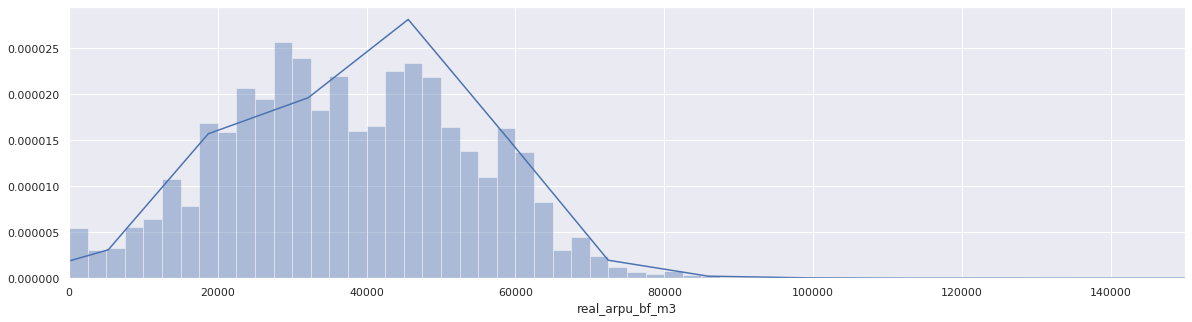

In [11]:
sns.set(rc={'figure.figsize': (20,5)})
plt.xlim(0,150000)
sns.distplot(df_merge['real_arpu_bf_m3'], bins=np.arange(0, 100000, 2500))

In [ ]:
sns.set(rc={'figure.figsize': (20,5)})
plt.xlim(0,150000)
sns.distplot(df_sample[df_sample['only_lg']==1]['real_arpu_bf_m2'], label='lg', bins=np.arange(0, 100000, 2500))
sns.distplot(df_sample[df_sample['only_lg']==0]['real_arpu_bf_m2'], label='not lg', bins=np.arange(0, 100000, 2500))
plt.legend()

In [ ]:
shap.dependence_plot('real_avg_arpu', shap_values[1], df_sample[feature_cols])

In [ ]:
shap.dependence_plot('real_arpu_bf_m1', shap_values[1], df_sample[feature_cols])

In [ ]:
shap.dependence_plot('real_arpu_bf_m2', shap_values[1], df_sample[feature_cols])